In [4]:
!nvidia-smi

Mon Jan 15 14:54:38 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:07:00.0 Off |                  N/A |
| 27%   34C    P8     7W / 250W |     18MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:41:00.0 Off |                  N/A |
| 27%   

In [2]:
import transformers
print(transformers.__version__)

4.20.0


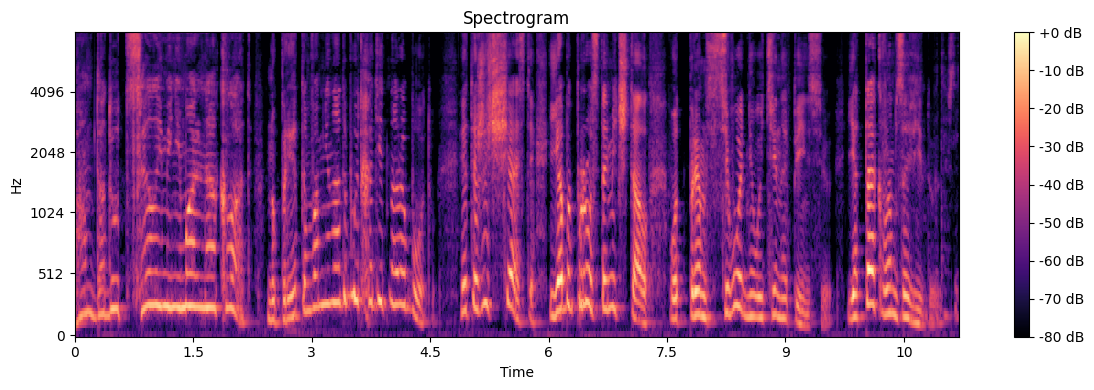

Ваша эмоция (SVM на MCCF): disgust
Ваша эмоция (SVM на MCCF): disgust
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (SVM на MCCF): disgust
Ваша эмоция (SVM на MCCF): disgust
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (wav2vec2-xlsr): sadness


In [19]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

# Load the .wav file into an array
# data, sample_rate = librosa.load('my-audio.wav', sr=None)
row = test_dataset[0]
emotion = row['emotion']
data = row['speech']['array']
sample_rate = row['speech']['sampling_rate']


# Create a spectrogram
spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128,fmax=8000)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_spectrogram, sr=sample_rate,
                         x_axis='time', y_axis='mel', fmax=8000)

plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

## Обучение SVM

Saving the dataset (1/1 shards): 100%|█████████████████████████████████| 280/280 [00:00<00:00, 1959.16 examples/s]
7it [00:36,  5.15s/it]
7it [00:08,  1.25s/it]


Accuracy: 0.55
Classification Report:
              precision    recall  f1-score   support

  enthusiasm       0.53      0.53      0.53        40
   happiness       0.44      0.66      0.53        44
     neutral       0.63      0.63      0.63        38
     sadness       0.63      0.59      0.61        32
     disgust       0.41      0.35      0.38        37
        fear       0.67      0.62      0.64        45
       anger       0.66      0.48      0.55        44

    accuracy                           0.55       280
   macro avg       0.57      0.55      0.55       280
weighted avg       0.57      0.55      0.55       280



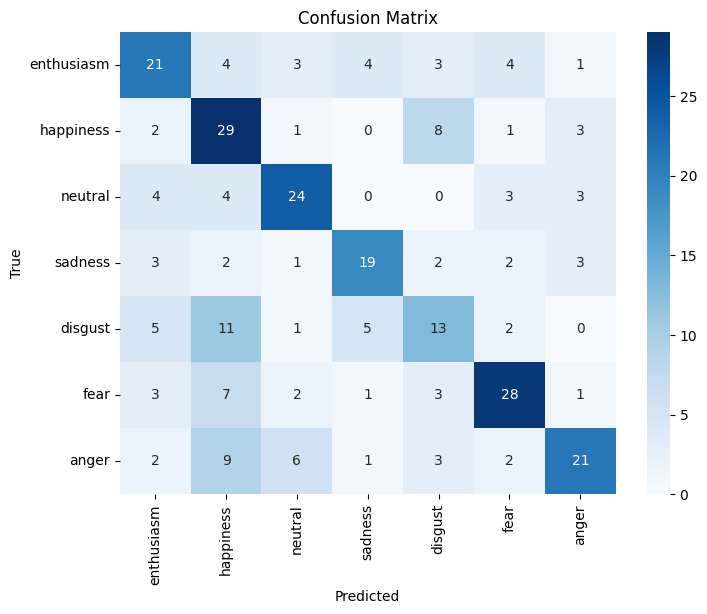

In [5]:
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from tqdm import tqdm


# Load audio files and extract features
def extract_features(audio, sr=16000):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=26)
    return np.mean(mfccs, axis=1)

# Define emotions and corresponding labels
emotions = ['enthusiasm', 'happiness', 'neutral', 'sadness', 'disgust', 'fear', 'anger']
labels = list(range(len(emotions)))

# Load and preprocess data
X_train = []
y_train = []
X_test = []
y_test = []


# Function to load and process data from the dataset
def load_and_process_data(dataset, X, y):
    for label, emotion in tqdm(enumerate(emotions)):
        for example in dataset:
            if example['emotion'] == emotion:
                audio_dict = example['speech']
                audio_array = audio_dict['array']
                # Assuming 'array' is the correct key for audio data
                audio = np.array(audio_array)
                sr = audio_dict['sampling_rate']
                features = extract_features(audio, sr=sr)
                X.append(features)
                y.append(label)


voice_emotion_dataset = load_dataset('Aniemore/resd')
voice_emotion_dataset.save_to_disk('resd')
train_dataset = voice_emotion_dataset['train']
test_dataset = voice_emotion_dataset['test']
# Load and preprocess training data
load_and_process_data(train_dataset, X_train, y_train)

# Convert lists to numpy arrays and concatenate features
if X_train:
    X_train = np.vstack(X_train)

# Train a Support Vector Machine (SVM) classifier
clf = SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)

# Make predictions on the test set
# (Assuming you want to test on the test dataset, please adjust if necessary)
load_and_process_data(test_dataset, X_test, y_test)

# Check if the test dataset is not empty
if X_test:
    X_test = np.vstack(X_test)
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=emotions))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
else:
    print("Test dataset is empty.")

    
    
import pickle
with open('svm.pkl','wb') as f:
    pickle.dump(clf, f)

In [11]:
def map_emotions(pred):
    emotions = ['enthusiasm', 'happiness', 'neutral', 'sadness', 'disgust', 'fear', 'anger']

    return emotions[pred]

def extract_features(audio, sr):
    audio = np.array(audio)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=26)
    return np.mean(mfccs, axis=1)


def predict_emotion_1(wav, clf, sr=48000):

    features = extract_features(wav, sr=sr)
    features = np.vstack(features).T

    prediction = clf.predict(features)[0]
    predicted_emotion = map_emotions(prediction)
    return predicted_emotion


In [13]:
import telebot
from telebot import apihelper
import pickle
import soundfile as sf

BOT_TOKEN = ''
bot = telebot.TeleBot(BOT_TOKEN)

with open('svm.pkl', 'rb') as f:
    clf = pickle.load(f)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoConfig, AutoModel, Wav2Vec2FeatureExtractor

import librosa
import numpy as np

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def speech_file_to_array_fn(path, sampling_rate=16000):
    speech_array, _sampling_rate = torchaudio.load(path)
    # resampler = torchaudio.transforms.Resample(_sampling_rate)
    # speech = resampler(speech_array).squeeze().numpy()
    speech = torchaudio.functional.resample(speech_array, orig_freq=_sampling_rate, new_freq=16000)
    speech = speech.squeeze().numpy()
    return speech


def prepare_wav(wav, sampling_rate=16000):
    tensor_waveform = torch.tensor(wav,dtype=torch.float).unsqueeze(0)
    
    resampler = torchaudio.transforms.Resample(sampling_rate)
    speech = resampler(tensor_waveform).squeeze().numpy()
    return speech


def predict_emotion_2(wav, sr=16000):
    speech = prepare_wav(wav, sr)
    inputs = feature_extractor(speech, sampling_rate=sr, return_tensors="pt", padding=True)
    inputs = {key: inputs[key].to(device) for key in inputs}

    with torch.no_grad():
        logits = model_(**inputs).logits



    scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    id = np.argmax(scores)
    prediction = config.id2label[id]
    # outputs = [{"Emotion": config.id2label[i], "Score": score} for i, score in enumerate(scores)]
    return prediction


TRUST = True

config = AutoConfig.from_pretrained('Aniemore/wav2vec2-xlsr-53-russian-emotion-recognition', trust_remote_code=TRUST)
model_ = AutoModel.from_pretrained("Aniemore/wav2vec2-xlsr-53-russian-emotion-recognition", trust_remote_code=TRUST)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("Aniemore/wav2vec2-xlsr-53-russian-emotion-recognition")

model_.to(device)

cpu


Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Downloading: 100%|███████████████████████████████████████████████████████████| 1.18G/1.18G [00:48<00:00, 26.2MB/s]
/home/lil-kirill/miniconda3/envs/py3_research/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Downloading: 100%|████████████████████████████████████████████████████

Wav2Vec2ForSpeechClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=Tr

## Проверка на тестовой выборке:

In [14]:
for row in test_dataset:
    emotion = row['emotion']
    
    data = row['speech']['array']
    sample_rate = row['speech']['sampling_rate']

    print("Истинное значение:", emotion)
    
    print("Предсказанное svm:", predict_emotion_1(data, clf, sample_rate))
    print("Предсказанное wav2vec-xlsr", predict_emotion_2(data, 16000))
    break

Истинное значение: neutral
Предсказанное svm: neutral
Предсказанное wav2vec-xlsr sadness


In [17]:
@bot.message_handler(commands=['start'])
def start(message):
    answer = f'Привет!\nЭто бот определния эмоций по Голосовому сообщению'
    bot.send_message(message.from_user.id, answer)
    bot.register_next_step_handler(message, get_emotion)


def get_emotion(message):
    if message.voice:
        bot.send_message(message.from_user.id, 'Скачиваю...')
        #1) Downloading wav from bot:
        try:
            file_info = bot.get_file(message.voice.file_id)
            wav_bytes = bot.download_file(file_info.file_path)

            with open(f'query_{message.from_user.id}', 'wb') as fp:
                fp.write(wav_bytes)

            wav, sr = sf.read(f'query_{message.from_user.id}')

            emotion_1 = predict_emotion_1(wav, clf, sr=sr)
            answer_1 = f'Ваша эмоция (SVM на MCCF): {emotion_1}'
            print(answer_1)
            
            emotion_2 = predict_emotion_2(wav, sr=16000)
            answer_2 = f'Ваша эмоция (wav2vec2-xlsr): {emotion_2}'
            print(answer_2)
            bot.send_message(message.from_user.id, answer_1)#, parse_mode='MarkdownV2')
            bot.send_message(message.from_user.id, answer_2)#, parse_mode='MarkdownV2')
            bot.register_next_step_handler(message, get_emotion)

        except Exception as Ex:
            print(Ex)
            bot.send_message(message.from_user.id, 'Что-то пошло не так с поиском, попробуй ещё раз.')
            bot.register_next_step_handler(message, get_emotion)
    else:
        bot.send_message(message.from_user.id, 'Что-то ты не то прислал. Попробуй ещё раз.')
        bot.register_next_step_handler(message, get_emotion)
    

In [20]:
print('ready')
bot.polling(none_stop=True, interval=0)

ready
Ваша эмоция (SVM на MCCF): anger
Ваша эмоция (SVM на MCCF): anger
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (SVM на MCCF): anger
Ваша эмоция (SVM на MCCF): anger
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (SVM на MCCF): enthusiasm
Ваша эмоция (SVM на MCCF): enthusiasm
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (SVM на MCCF): enthusiasm
Ваша эмоция (SVM на MCCF): enthusiasm
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (SVM на MCCF): disgust
Ваша эмоция (SVM на MCCF): disgust
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (SVM на MCCF): disgust
Ваша эмоция (SVM на MCCF): disgust
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (SVM на MCCF): disgust
Ваша эмоция (SVM на MCCF): disgust
Ваша эмоция (wav2vec2-xlsr): sadness
Ваша эмоция (wav2ve